In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:0000:010:01


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import requests

# Random seed for reproducibility
np.random.seed(42)

# Scrape NVIDIA stock data from Alpha Vantage

In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("API_KEY")

api_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=NVDA&outputsize=full&apikey={api_key}"

response = requests.get(api_url)
data = response.json()

time_series = data['Time Series (Daily)']
rows = []
for date, values in time_series.items():
    rows.append({
        'Date': date,
        'Open': float(values['1. open']),
        'High': float(values['2. high']),
        'Low': float(values['3. low']),
        'Close': float(values['4. close']),
        'Volume': int(values['5. volume'])
    })

df = pd.DataFrame(rows)
df = df.sort_values(by='Date')
df.to_csv('nvidia.us.txt', sep=',', index=False)

# Load and preprocess stock data

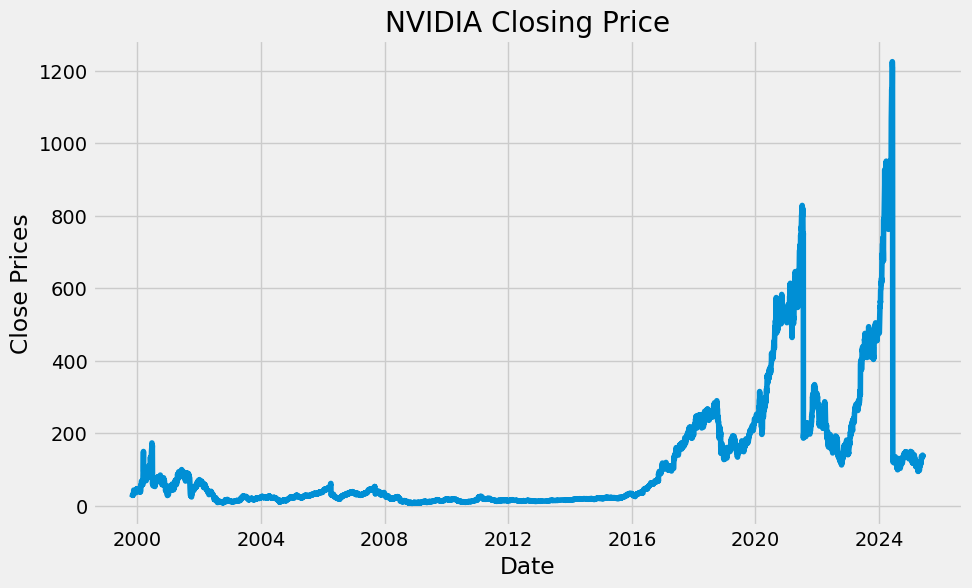

In [5]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv('nvidia.us.txt', sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)

# Forward-fill missing values (if any)
stock_data.fillna(method='ffill', inplace=True)

# Extract Close price
df_close = stock_data['Close']

# Plot Close Price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close)
plt.title('NVIDIA Closing Price')
plt.show()

# Stationarity Test Function

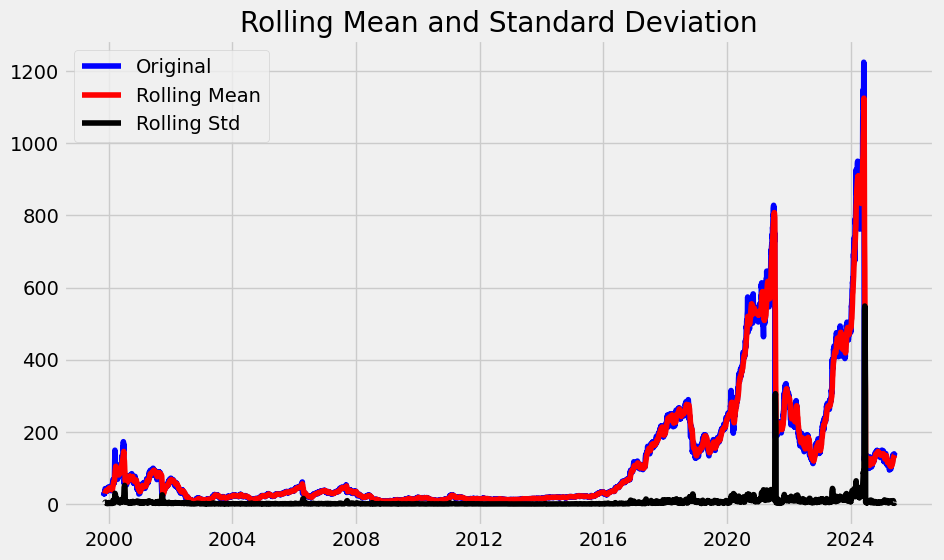

Results of Dickey-Fuller Test:
Test Statistic            -3.542878
p-value                    0.006952
#Lags Used                11.000000
#Observations           6425.000000
Critical Value (1%)       -3.431368
Critical Value (5%)       -2.861990
Critical Value (10%)      -2.567010
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

# Run stationarity test
test_stationarity(df_close)

# Seasonal Decomposition

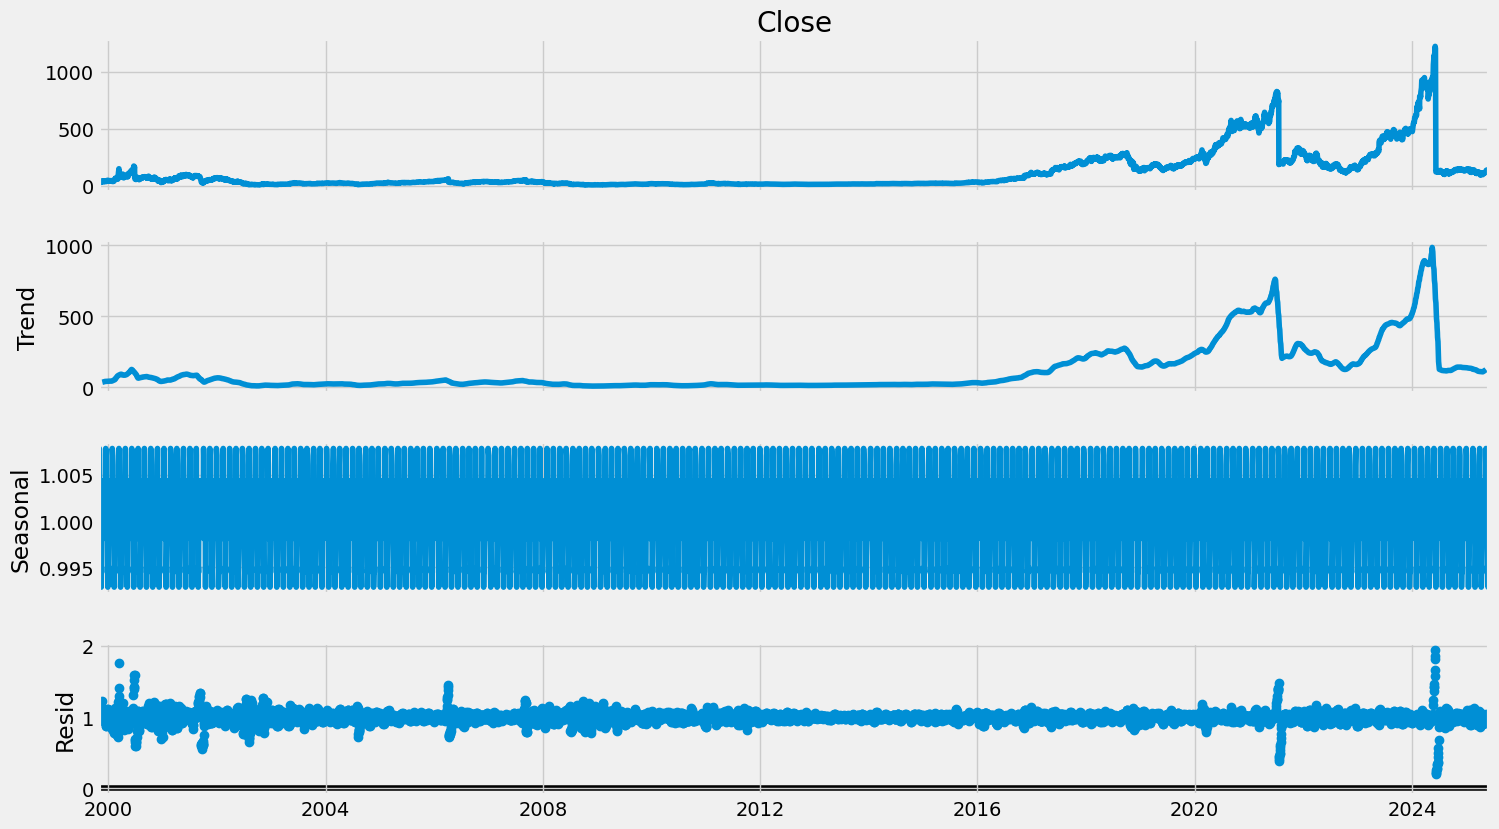

In [7]:
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

# Resample data to Business Days and Log Transform
df_close = df_close.sort_index().asfreq('B')
df_close.fillna(method='ffill', inplace=True)

df_log = np.log(df_close)

# Rolling Mean and Std Dev after Log Transform

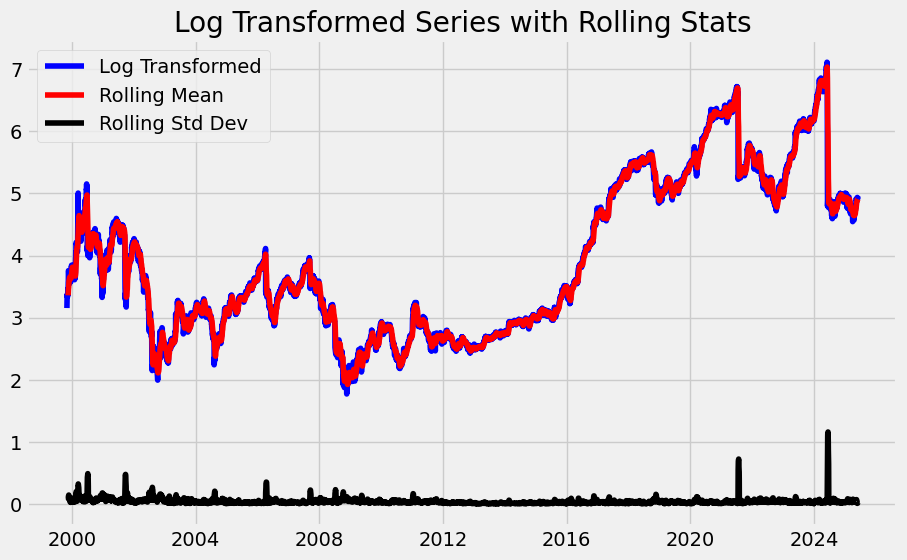

In [8]:
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.plot(df_log, color='blue', label='Log Transformed')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.plot(std_dev, color='black', label='Rolling Std Dev')
plt.legend()
plt.title('Log Transformed Series with Rolling Stats')
plt.show()

# Train-Test Split

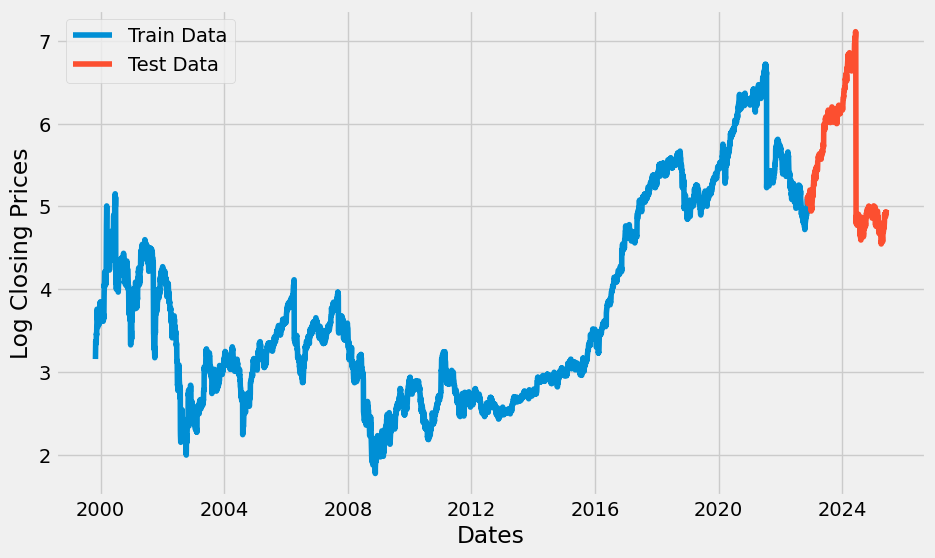

In [9]:
split_idx = int(len(df_log) * 0.9)
train_data = df_log[:split_idx]
test_data = df_log[split_idx:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log Closing Prices')
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.legend()
plt.show()

# Auto ARIMA Model Selection

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20180.488, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20179.087, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-20179.041, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20182.181, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20177.301, Time=0.80 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.554 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6010
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10092.090
Date:                Wed, 04 Jun 2025   AIC                         -20182.181
Time:                        20:45:36   BIC                         -20175.480
Sample:                    11-01-1999   HQIC                        -20179.854
                         - 11-11-2022                             

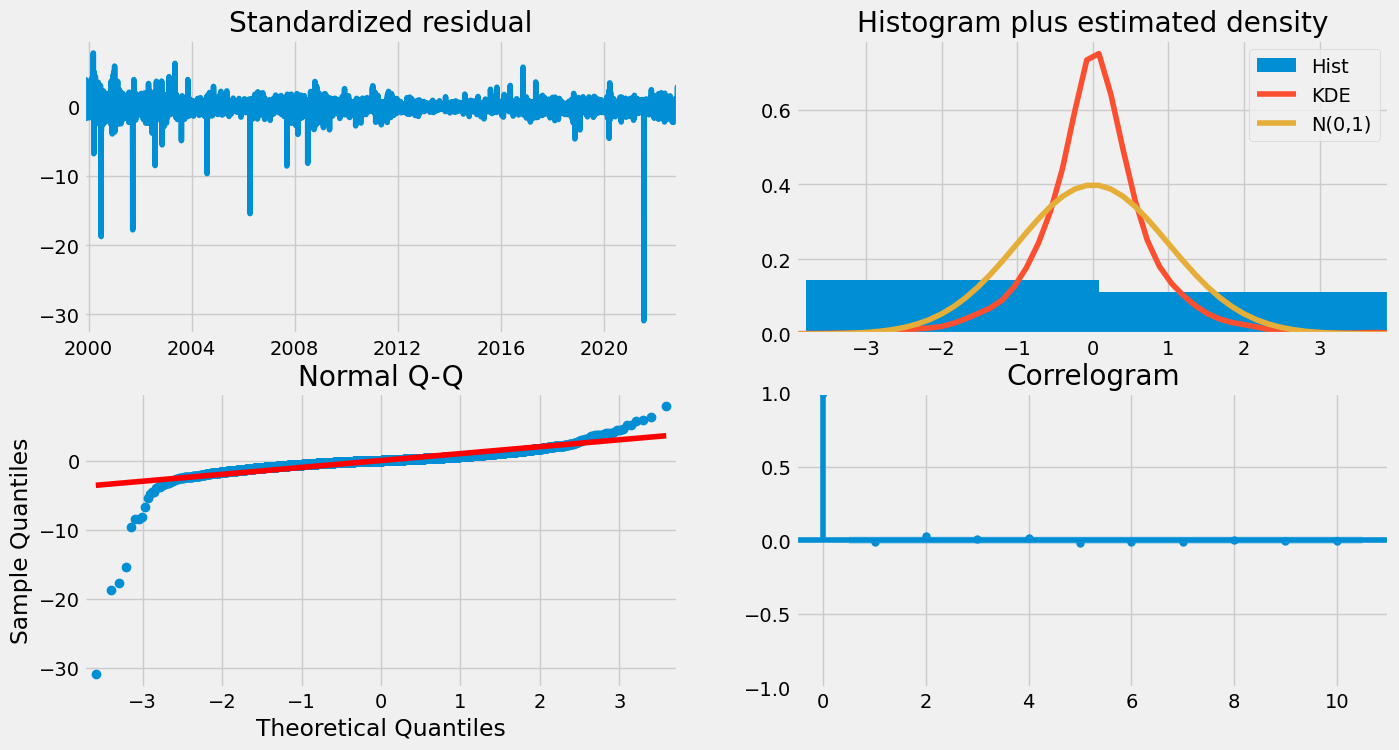

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf', max_p=3, max_q=3,
                      m=1, d=None, seasonal=False,
                      trace=True, error_action='ignore',
                      suppress_warnings=True, stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# Fit ARIMA Model using statsmodels

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6010
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10095.074
Date:                Wed, 04 Jun 2025   AIC                         -20182.148
Time:                        20:45:37   BIC                         -20155.344
Sample:                    11-01-1999   HQIC                        -20172.840
                         - 11-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0884      0.340      0.260      0.795      -0.578       0.755
ma.L1         -0.0988      0.341     -0.290      0.772      -0.767       0.569
ma.L2          0.0302      0.009      3.364      0.0

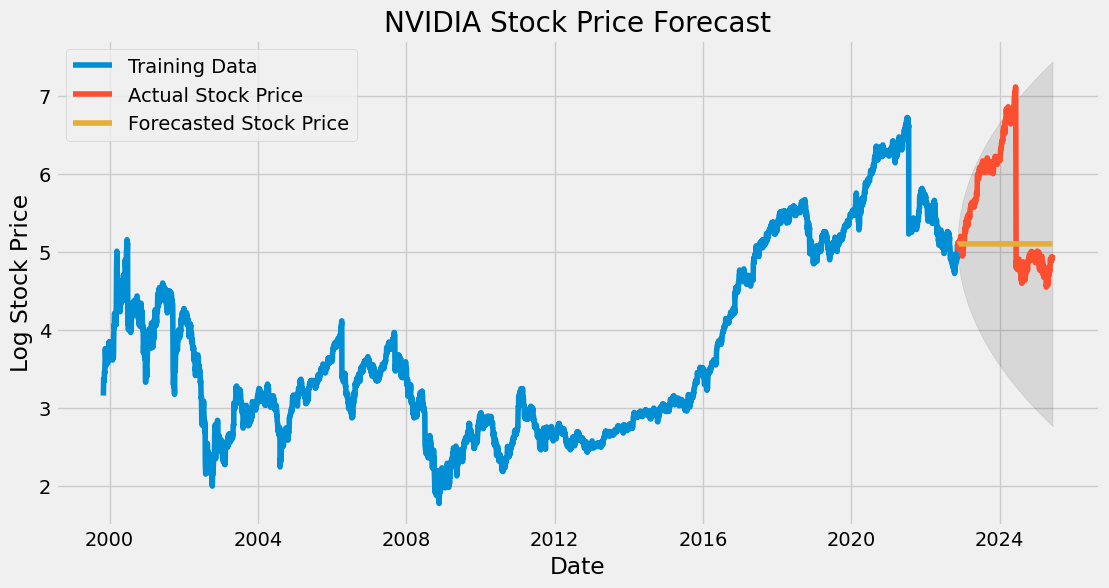

In [11]:
# Use best order from auto_arima, e.g., (1,1,2)
model = ARIMA(train_data, order=(1, 1, 2))
fitted = model.fit()
print(fitted.summary())

# Forecasting
forecast_steps = len(test_data)
forecast_result = fitted.get_forecast(steps=forecast_steps)

fc = forecast_result.predicted_mean
se = forecast_result.se_mean
conf = forecast_result.conf_int(alpha=0.05)

# Forecast Index
forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='B')
fc_series = pd.Series(fc.values, index=forecast_index)

# Plotting Forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(fc_series, label='Forecasted Stock Price')
plt.fill_between(forecast_index, conf.iloc[:,0], conf.iloc[:,1], color='k', alpha=0.1)
plt.title('NVIDIA Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.legend()
plt.show()

# Evaluation Metrics

In [12]:
# Align lengths for metric calculation
fc_aligned = fc_series[:len(test_data)]

mse = mean_squared_error(test_data, fc_aligned)
mae = mean_absolute_error(test_data, fc_aligned)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(fc_aligned - test_data) / np.abs(test_data))

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAPE: {mape:.4%}')

MSE: 0.7342
MAE: 0.6714
RMSE: 0.8568
MAPE: 11.1689%


# LSTM Model for Stock Price Prediction

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Rescale the train and test data
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

# Convert data to sequences (time steps)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Using 60 time steps (same as common ARIMA model order)
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, y_test = create_dataset(test_data_scaled, time_step)

# Reshape inputs to be 3D (samples, time steps, features) for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
# LSTM model with adjusted parameters
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model_lstm.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))  # Output layer (single prediction)

# Compile model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model (epochs to 20 for a reasonable duration for comparison)
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
lstm_predictions = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Convertion of test data back to original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Generate the dates corresponding to the test set predictions
forecast_index_lstm = pd.date_range(start=test_data.index[time_step], periods=len(lstm_predictions), freq='B')

Epoch 1/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0222 - val_loss: 0.0020
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 11/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

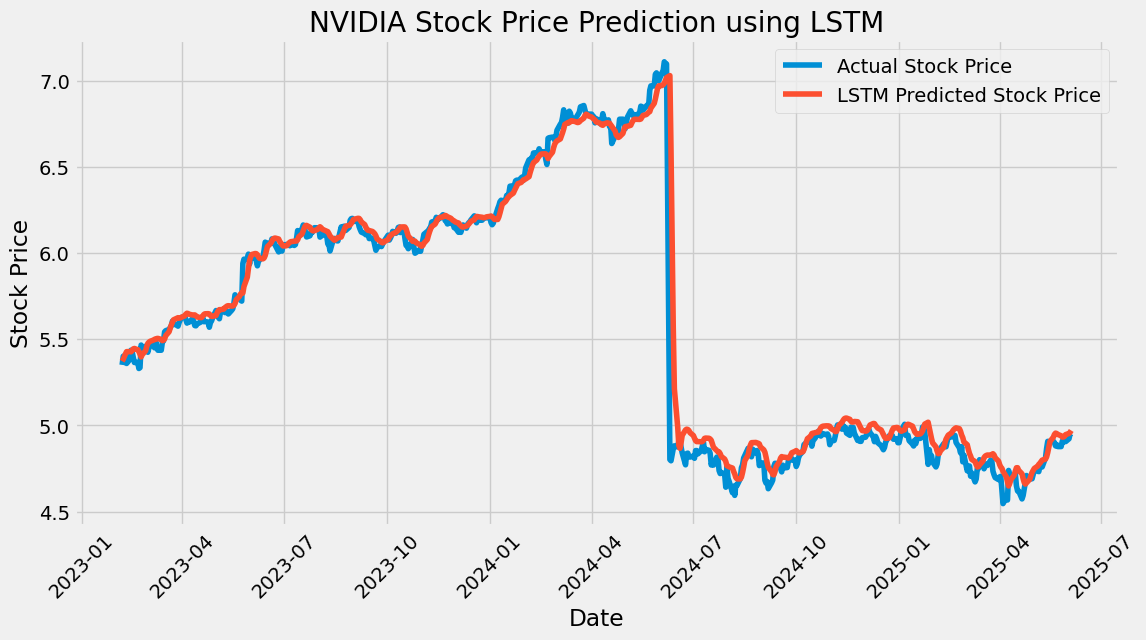

In [15]:
# Plot LSTM predictions vs actual values with correct dates
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[time_step:], y_test_rescaled, label='Actual Stock Price')
plt.plot(forecast_index_lstm, lstm_predictions, label='LSTM Predicted Stock Price')
plt.title('NVIDIA Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [16]:
mse_lstm = mean_squared_error(y_test_rescaled, lstm_predictions)
mae_lstm = mean_absolute_error(y_test_rescaled, lstm_predictions)
rmse_lstm = math.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs(lstm_predictions - y_test_rescaled) / np.abs(y_test_rescaled))

print(f'LSTM MSE: {mse_lstm:.4f}')
print(f'LSTM MAE: {mae_lstm:.4f}')
print(f'LSTM RMSE: {rmse_lstm:.4f}')
print(f'LSTM MAPE: {mape_lstm:.4%}')

LSTM MSE: 0.0205
LSTM MAE: 0.0560
LSTM RMSE: 0.1433
LSTM MAPE: 1.0688%


In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt

def create_dataset(data, look_back=60):  # Matching the time step with LSTM model
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 60  # Match this with LSTM time_step and ARIMA rolling window
X_train, y_train = create_dataset(train_data.values, look_back)
X_test, y_test = create_dataset(test_data.values, look_back)

# Reshape input data for XGBoost (must be 2D array for XGBoost)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Instantiate and train the XGBoost model
xg_model = xgb.XGBRegressor(objective='reg:squarederror', 
                            n_estimators=1000, 
                            max_depth=5, 
                            learning_rate=0.01, 
                            subsample=0.8, 
                            colsample_bytree=0.8)
xg_model.fit(X_train, y_train)

# Forecasting with XGBoost
xg_train_preds = xg_model.predict(X_train)
xg_test_preds = xg_model.predict(X_test)

# Plotting XGBoost Predictions vs Actual

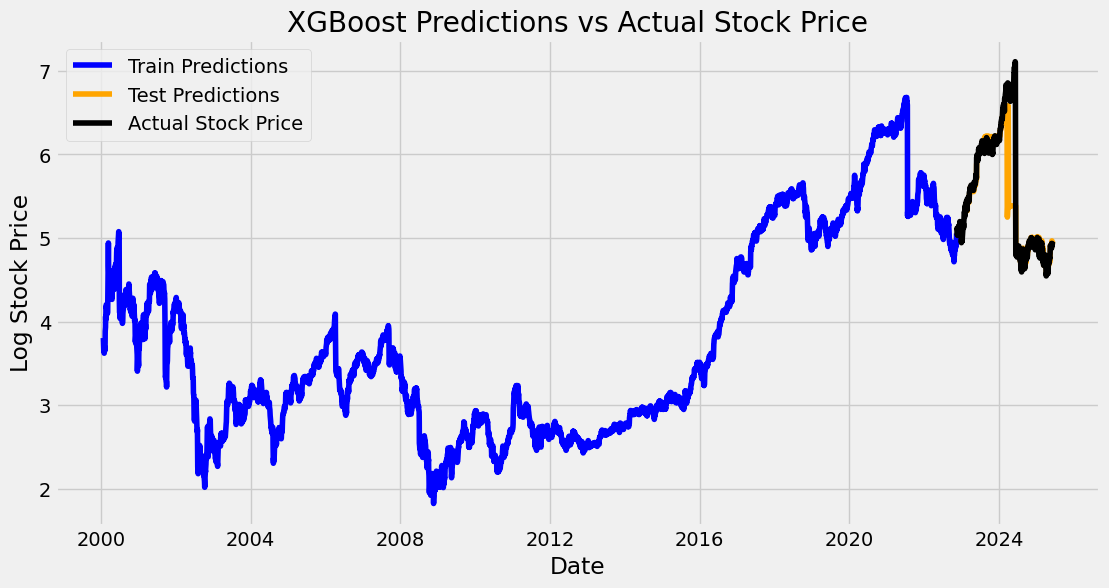

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[look_back:], xg_train_preds, label='Train Predictions', color='blue')
plt.plot(test_data.index[look_back:], xg_test_preds, label='Test Predictions', color='orange')
plt.plot(test_data.index, test_data.values, label='Actual Stock Price', color='black')
plt.title('XGBoost Predictions vs Actual Stock Price')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.legend()
plt.show()

# XGBoost Evaluation Metrics

In [19]:
# Evaluate on test data
mse = mean_squared_error(y_test, xg_test_preds)
mae = mean_absolute_error(y_test, xg_test_preds)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(xg_test_preds - y_test) / np.abs(y_test))

print(f'XGBoost MSE: {mse:.4f}')
print(f'XGBoost MAE: {mae:.4f}')
print(f'XGBoost RMSE: {rmse:.4f}')
print(f'XGBoost MAPE: {mape:.4%}')

XGBoost MSE: 0.2074
XGBoost MAE: 0.1822
XGBoost RMSE: 0.4554
XGBoost MAPE: 2.7922%
